In [1]:
import glob
import re
import pandas as pd
import numpy as np
from functools import *



In [5]:
def sclean1(s):
    parts = s.split("d ")
    day  = int(parts[0])
    time = parts[1]
    z=sum(x * float(t) for x, t in zip([1/60, 1, 60], reversed(time.split(":"))))+day*1440
    return z

def tweak1(df,x):
    trans={"U01":"Vendor","U02":"FW1","U03":"FW2","U04":"LT1","U05":"LT2","U06":"LH1","U07":"LH2"}
    uut = "U"+re.search('_U(.+?)_', x)[1]
    t = trans[uut]
    return (df
           .assign(Stime = lambda df_:df_['StepTime'].map(sclean1), UUT=uut, Test= t)
           .drop('StepTime', axis=1)
           )

In [6]:
# Let's shorten up pd.read_csv command a bit
pcsv = partial(pd.read_csv, skiprows=4,sep="\t", header=0, usecols=[0,1,2,4,5,7,8,9],index_col=0)

In [7]:
l = pd.concat([tweak1(pcsv(x),x) for x in glob.glob("Data/*.txt")])
l.query("State=='D'",inplace=True)
l.query('UUT != "U06" and UUT != "U07"',inplace=True)
l

,Cyc#,Step,Amp-hr,Amps,Volts,State,Stime,UUT,Test
Rec#,,,,,,,,,
3,1,4,0.00000,0.00007,3.49744,D,0.000833,U01,Vendor
4,1,4,0.00000,0.00375,2.60517,D,0.006833,U01,Vendor
31,2,4,0.00000,0.00000,0.51781,D,0.000000,U01,Vendor
58,3,4,0.00000,0.00000,0.00000,D,0.000000,U01,Vendor
85,4,4,0.00000,0.00000,0.00000,D,0.000000,U01,Vendor
...,...,...,...,...,...,...,...,...,...
56852,273,4,0.34397,0.24002,3.16060,D,86.001000,U05,LT2
56853,273,4,0.34797,0.23987,3.12764,D,87.001000,U05,LT2
56854,273,4,0.35197,0.23995,3.08896,D,88.001000,U05,LT2


In [11]:
dis = (l
       .groupby(['UUT'])
       .agg({"Amp-hr":"max"})
       )
z=dict(dis.reset_index().values)
print(z)

df = (l
            .groupby(['UUT','Cyc#'])
            .agg({"Amp-hr":"max"})
            .reset_index()
            .assign(Ah  = lambda df_:df_['Amp-hr']/df_['UUT'].map(z))
            .drop("Amp-hr",axis=1)
            .query("Ah>0.81")
            )
df

{'U01': 0.45813, 'U02': 0.41719, 'U03': 0.42328, 'U04': 0.41308, 'U05': 0.42374}


,UUT,Cyc#,Ah
8,U01,9,0.995525
9,U01,10,0.993648
10,U01,11,0.995722
11,U01,12,1.000000
12,U01,13,0.997970
...,...,...,...
1085,U05,267,0.850168
1086,U05,268,0.849955
1089,U05,271,0.847241
1090,U05,272,0.847076


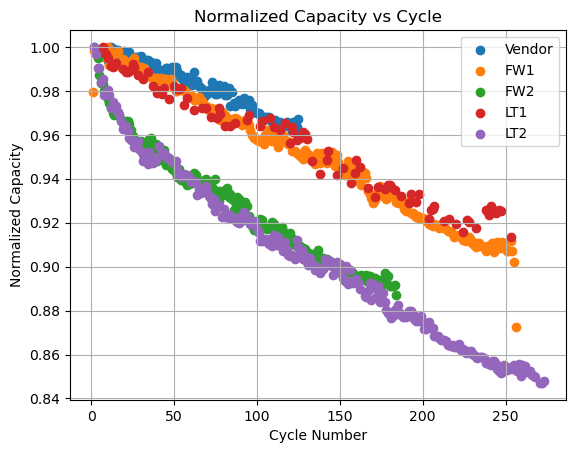

In [26]:
#colors = {'U01':'red', 'U02':'green', 'U03':'springgreen', 'U04':'indigo','U05':'plum'}
#lfix.groupby("UUT").plot(x="Cyc#", y="Ah",legend=True, xlabel="Cycle", ylabel="Normalized Capacity",kind="scatter")

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
trans={"U01":"Vendor","U02":"FW1","U03":"FW2","U04":"LT1","U05":"LT2","U06":"LH1","U07":"LH2"}
for name in ['U01','U02','U03','U04','U05']:
    ax.scatter(df[df.UUT==name]['Cyc#'],df[df.UUT==name].Ah,label=trans[name])

ax.set_xlabel("Cycle Number")
ax.set_ylabel("Normalized Capacity")
ax.set_title("Normalized Capacity vs Cycle")
ax.grid()
ax.legend(loc='best')